## *Predicting Insurance Costs With Regression Models*

Welcome, and thank you for joining me today.  

This project revolves around a critical question faced by insurance companies: **How can we accurately predict the cost of insurance for customers?** Understanding and predicting insurance costs is essential for businesses in this industry, as it directly impacts pricing strategies, risk assessment, and profitability. A well-designed predictive model not only ensures fair pricing for customers but also helps companies manage financial risks effectively.

To address this problem, I applied a complete data science workflow. The project involved several key steps: **data cleaning**, where the foundation of any reliable analysis is laid; **model selection and comparison**, to find the most effective predictive techniques; **hyperparameter tuning**, to refine model performance; and finally, **applying the model to new data**, demonstrating its practicality in a real-world context.

By tackling this challenge, I aimed to showcase my technical skills while addressing a problem with significant business implications. In order to achieve this, we will be working on the following dataset.

## Dataset: insurance.csv
| Column    | Data Type | Description                                                      |
|-----------|-----------|------------------------------------------------------------------|
| `age`       | int       | Age of the primary beneficiary.                                  |
| `sex`       | object    | Gender of the insurance contractor (male or female).             |
| `bmi`       | float     | Body mass index, a key indicator of body fat based on height and weight. |
| `children`  | int       | Number of dependents covered by the insurance plan.              |
| `smoker`    | object    | Indicates whether the beneficiary smokes (yes or no).            |
| `region`    | object    | The beneficiary's residential area in the US, divided into four regions. |
| `charges`   | float     | Individual medical costs billed by health insurance.             |



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

In [2]:
insurance_data_path = 'insurance.csv'
insurance = pd.read_csv(insurance_data_path)

## **Preparing the data**
Data preparation is the cornerstone of any successful machine learning project. Here's how we tackle this important phase:  
- **Missing Data**: Imputed or removed missing values to ensure the dataset was complete.  
- **Normalization**: Scaled numerical variables for consistency across features.  
- **Encoding Categorical Variables**: Converted categories into numerical representations suitable for modeling.  

This step ensured a clean and robust dataset, ready for analysis and modeling


### Data Exploration

Getting to know the database is the first step in the process of reforming it to match the desired criteria.

In [3]:
insurance_filled = insurance.copy().dropna()

insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552


In [4]:
insurance.describe()

,age,bmi,children
count,1272.000000,1272.000000,1272.000000
mean,35.214623,30.560550,0.948899
std,22.478251,6.095573,1.303532
min,-64.000000,15.960000,-4.000000
25%,24.750000,26.180000,0.000000
50%,38.000000,30.210000,1.000000
75%,51.000000,34.485000,2.000000
max,64.000000,53.130000,5.000000


In [5]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1272 non-null   float64
 1   sex       1272 non-null   object 
 2   bmi       1272 non-null   float64
 3   children  1272 non-null   float64
 4   smoker    1272 non-null   object 
 5   region    1272 non-null   object 
 6   charges   1284 non-null   object 
dtypes: float64(3), object(4)
memory usage: 73.3+ KB


In [6]:
insurance.shape

(1338, 7)

In [7]:
insurance.sample(10)

,age,sex,bmi,children,smoker,region,charges
8,37.0,male,29.830,2.0,no,Northeast,$6406.4107
591,47.0,male,19.570,1.0,no,northwest,8428.0693
311,19.0,woman,24.700,0.0,no,southwest,1737.376
71,31.0,man,28.500,5.0,no,Northeast,6799.458
464,19.0,male,25.175,0.0,no,Northwest,1632.03625
873,43.0,male,30.100,1.0,no,southwest,6849.026
366,56.0,female,32.300,3.0,no,Northeast,13430.265
424,48.0,male,30.200,2.0,no,southwest,8968.33
902,26.0,male,27.265,3.0,no,northeast,4661.28635
145,29.0,female,38.830,3.0,no,southeast,5138.2567


### Data cleaning

Once we know the data, we can start adjusting it to our needs. 

In [8]:
insurance_filled["region"] = insurance_filled["region"].str.lower()

sex_mapping = {"F": "female", "woman": "female", "M": "male", "man": "male"}
insurance_filled["sex"] = insurance_filled["sex"].replace(sex_mapping)

insurance_filled["smoker"] = insurance_filled["smoker"] == "yes"

#To get rid of negatives because they didn't make sense if the context of the dataset
insurance_filled["charges"] = insurance_filled["charges"].str.strip("$").astype("float64")

insurance_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1208 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1208 non-null   float64
 1   sex       1208 non-null   object 
 2   bmi       1208 non-null   float64
 3   children  1208 non-null   float64
 4   smoker    1208 non-null   bool   
 5   region    1208 non-null   object 
 6   charges   1207 non-null   float64
dtypes: bool(1), float64(4), object(2)
memory usage: 67.2+ KB


In [9]:
insurance_clean = insurance_filled.apply(lambda x: x.abs() if np.issubdtype(x.dtype, np.number) else x)

insurance_clean.sample(10)

,age,sex,bmi,children,smoker,region,charges
276,19.0,male,20.615,2.0,False,northwest,2803.69785
133,19.0,male,25.555,0.0,False,northwest,1632.56445
381,55.0,male,30.685,0.0,True,northeast,42303.69215
582,39.0,male,45.430,2.0,False,southeast,6356.27070
27,55.0,female,32.775,2.0,False,northwest,12268.63225
515,58.0,male,35.700,0.0,False,southwest,11362.75500
971,34.0,female,23.560,0.0,False,northeast,4992.37640
589,38.0,female,30.690,1.0,False,southeast,5976.83110
1005,29.0,male,31.730,2.0,False,northwest,4433.38770
703,34.0,female,26.410,1.0,False,northwest,5385.33790


In [10]:
insurance_clean.to_csv("insurance_clean.csv", index=False)

### Prepare the data for model fitting

Before fitting any machine learning model, it’s essential to ensure that the dataset is properly prepared. This step involves transforming raw data into a clean and structured format that models can effectively interpret.

In [11]:
df = pd.read_csv("insurance_clean.csv")

model_df = pd.get_dummies(df, prefix=["region"], columns=["region"])
model_df = model_df.drop(columns=["region_southeast"])
model_df["smoker"] = model_df["smoker"].astype("int64")

model_df["is_male"] = (model_df["sex"] == "male").astype("int64")

model_df = model_df.drop(columns=["sex"])

model_df = model_df.dropna()

model_df.head()

,age,bmi,children,smoker,charges,region_northeast,region_northwest,region_southwest,is_male
0,19.0,27.900,0.0,1,16884.92400,False,False,True,0
1,18.0,33.770,1.0,0,1725.55230,False,False,False,1
2,28.0,33.000,3.0,0,4449.46200,False,False,False,1
3,33.0,22.705,0.0,0,21984.47061,False,True,False,1
4,32.0,28.880,0.0,0,3866.85520,False,True,False,1


## Building the model

Building the model is a process that involves both understanding of the data, and focus towards the desired goals. Choosing the model and the training method is an important decision, that's why it is important to unveil the hidden connections between the different variables before commiting to use an specific model.

### Discovering the relationships

Understanding the relationships between variables is a crucial step in building predictive models. It's important to analyze the correlations between features and the target variable (charges) to identify the most influential predictors. Visual tools such as scatter plots and heatmaps that the only strong relationship was actually found within the "Smoker" variable.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'smoker'}>],
       [<Axes: title={'center': 'charges'}>,
        <Axes: title={'center': 'is_male'}>]], dtype=object)

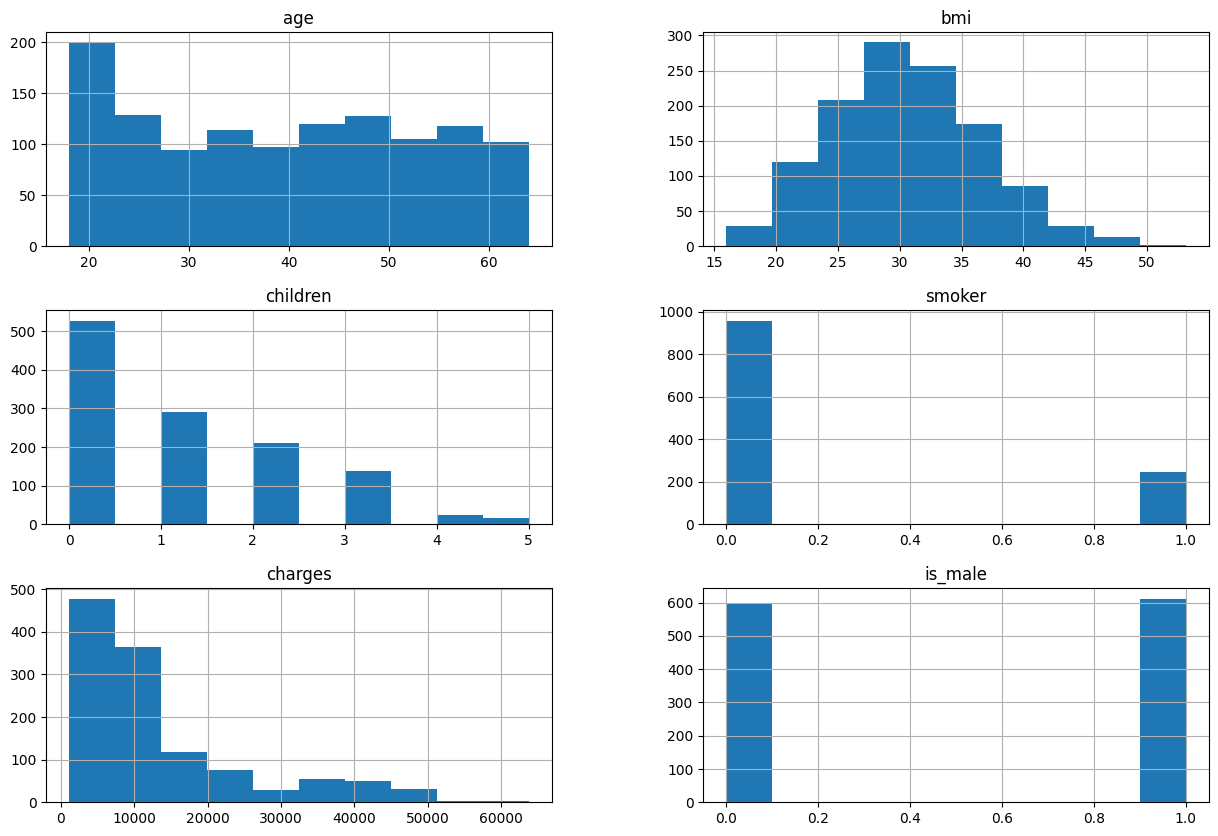

In [12]:
model_df.hist(figsize=(15,10))

<Axes: >

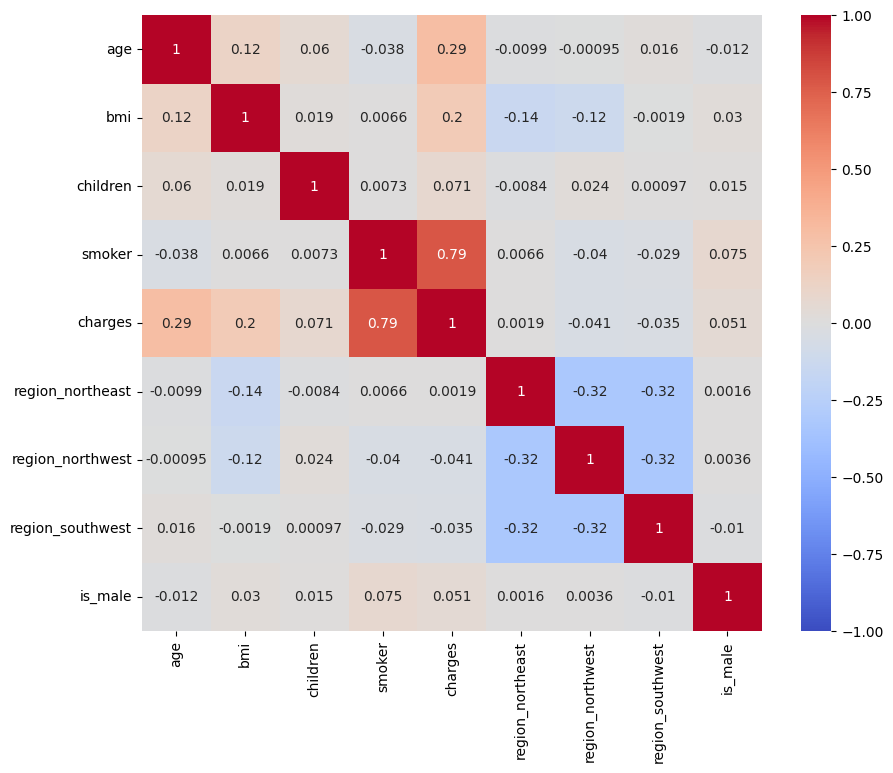

In [13]:
plt.figure(figsize=[10,8])
sns.heatmap(model_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)

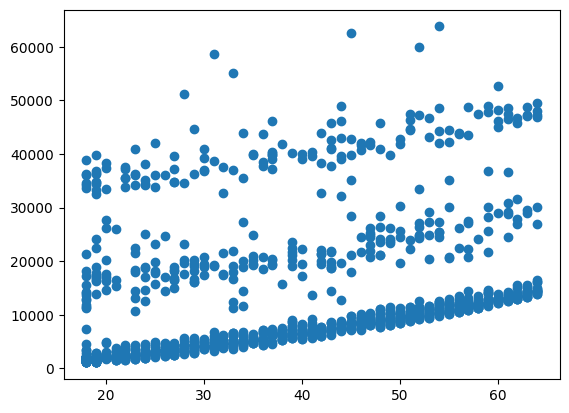

In [14]:
plt.scatter(model_df["age"], model_df["charges"])

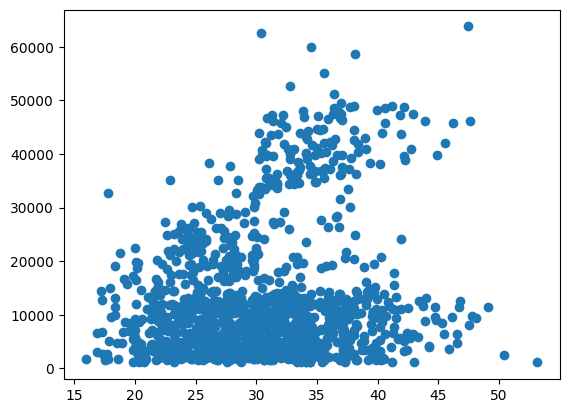

In [15]:
plt.scatter(model_df["bmi"], model_df["charges"])

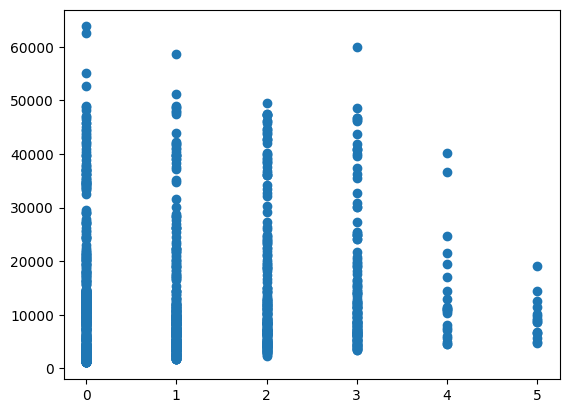

In [16]:
plt.scatter(model_df["children"], model_df["charges"])

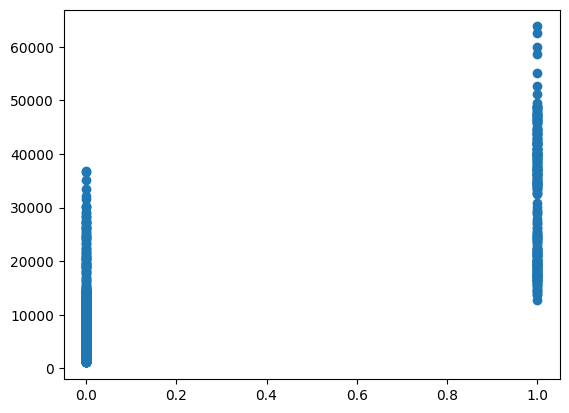

In [17]:
plt.scatter(model_df["smoker"], model_df["charges"])

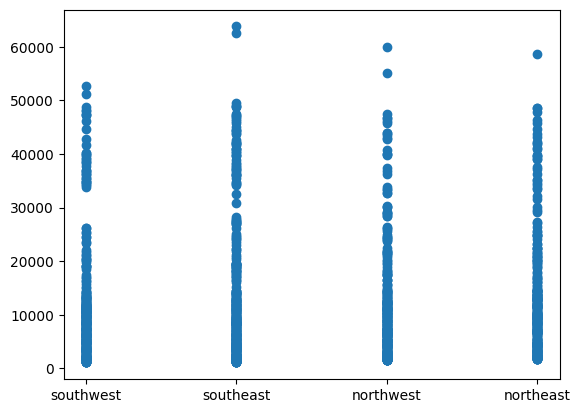

In [18]:
plt.scatter(df["region"], df["charges"])

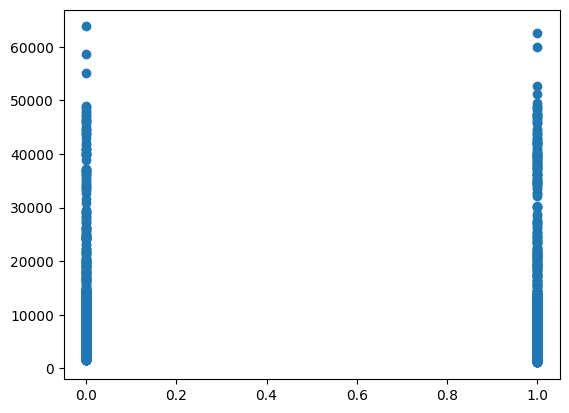

In [19]:
plt.scatter(model_df["is_male"], model_df["charges"])

### **Training the model**
To predict insurance costs, we'll evaluate two models:

**Linear Regression**
- A straightforward model to understand relationships in data.  
- Ideal for datasets with linear patterns but may struggle with complex interactions.  

**Random Forest Regression**
- A more sophisticated ensemble method that captures non-linear relationships effectively.  
- While powerful, it requires tuning to avoid overfitting and optimize performance.

The initial results showed that Random Forest outperformed Linear Regression in terms of predictive accuracy, especially with more complex patterns.


In [20]:
X = model_df.drop(columns=["charges"])
y = model_df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
linear_y_predict = model_linear.predict(X_test)

model_forest = RandomForestRegressor(n_jobs=1)
model_forest.fit(X_train, y_train)

forest_y_predict = model_forest.predict(X_test)

print("Initial test score")
print(f"Linear score:{model_linear.score(X_test, y_test)}")
print(f"Forest score:{model_forest.score(X_test, y_test)}")

Initial test score
Linear score:0.7049323160872817
Forest score:0.8206838233843838


In [21]:
cross_score_linear = cross_val_score(estimator=model_linear, X=X, y=y, scoring="r2", cv=5)
cross_score_forest = cross_val_score(estimator=model_forest, X=X, y=y, scoring="r2", cv=5)

print("Cross val score - Higher = better")
print(f"Linear score:{cross_score_linear.mean()}")
print(f"Forest score:{cross_score_forest.mean()}")

Cross val score - Higher = better
Linear score:0.7442527809757057
Forest score:0.8368737534426767


In [22]:
r2_linear = r2_score(y_test, linear_y_predict)
r2_forest = r2_score(y_test, forest_y_predict)

print("r2 Score - Higher = better")
print(f"Linear score:{r2_linear}")
print(f"Forest score:{r2_forest}")

r2 Score - Higher = better
Linear score:0.7049323160872817
Forest score:0.8206838233843838


In [23]:
rmse_linear = root_mean_squared_error(y_test, linear_y_predict)
rmse_forest = root_mean_squared_error(forest_y_predict, y_test)
print("Root Mean Squared Error - Lower = better")
print(f"Linear score:{rmse_linear}")
print(f"Forest score:{rmse_forest}")

Root Mean Squared Error - Lower = better
Linear score:6319.54217986643
Forest score:4926.455090703199


In [24]:
mae_linear = mean_absolute_error(linear_y_predict, y_test)
mae_forest = mean_absolute_error(forest_y_predict, y_test)
print("Mean Absolute Error - Lower = better")
print(f"Linear score:{mae_linear}")
print(f"Forest score:{mae_forest}")

Mean Absolute Error - Lower = better
Linear score:4378.723562983686
Forest score:2890.690395782397


### Comparing the performance

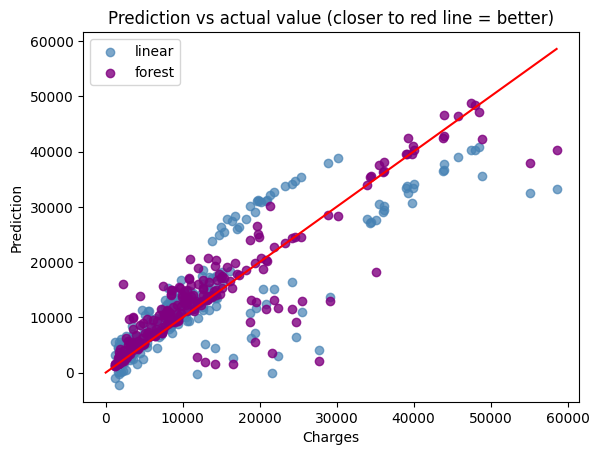

In [25]:
plt.scatter(y_test, linear_y_predict, color=(70/255, 130/255, 180/255, 0.7), label="linear")
plt.scatter(y_test, forest_y_predict, color=(128/255, 0/255, 128/255, 0.8), label="forest")
plt.plot(np.linspace(0, max(y_test)), np.linspace(9, max(y_test)), color="red")
plt.xlabel("Charges")
plt.ylabel("Prediction")
plt.title("Prediction vs actual value (closer to red line = better)")
plt.legend()

### Unveiling the feature importances

To understand which factors significantly influence insurance costs, I compared feature importances derived from the models. For this, the forest model seemed to spot weaker but relevant relationships on the variables "BMI" and "Age".

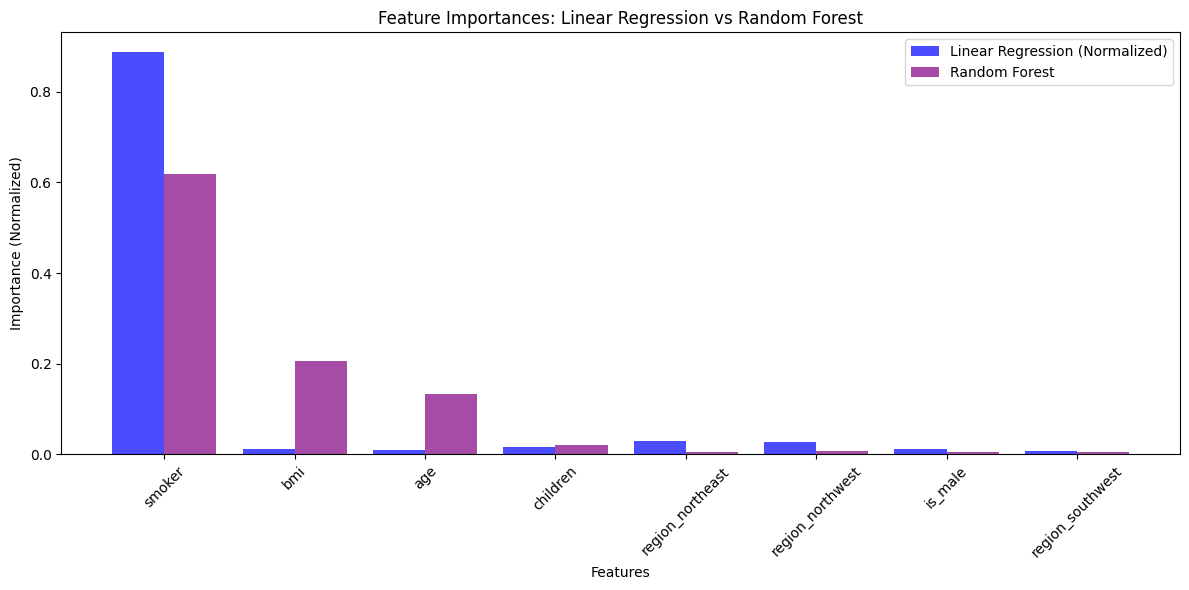

In [26]:
linear_coef = model_linear.coef_
linear_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": linear_coef
}).sort_values(by="Importance", key=abs, ascending=False)

# Linear refression importances
linear_total = linear_importances["Importance"].abs().sum()
linear_importance_normalized = (linear_importances["Importance"].abs() / linear_total).tolist()

linear_dict = dict(zip(linear_importances["Feature"], linear_importance_normalized))

# Random Forest Importances
forest_importances = sorted(
    zip(model_forest.feature_names_in_, model_forest.feature_importances_),
    key=lambda x: x[1],
    reverse=True
)
forest_dict = dict(forest_importances)

# Combine and sort importances
all_features = sorted(set(linear_dict.keys()).union(forest_dict.keys()))
linear_aligned = [linear_dict.get(feature, 0) for feature in all_features]
forest_aligned = [forest_dict.get(feature, 0) for feature in all_features]

combined_importance = [linear + forest for linear, forest in zip(linear_aligned, forest_aligned)]

sorted_indices = np.argsort(combined_importance)[::-1] 
all_features = [all_features[i] for i in sorted_indices]
linear_aligned = [linear_aligned[i] for i in sorted_indices]
forest_aligned = [forest_aligned[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(12, 6))
bar_width = 0.4
positions = np.arange(len(all_features))
plt.bar(positions - bar_width/2, linear_aligned, bar_width, label="Linear Regression (Normalized)", color="blue", alpha=0.7)
plt.bar(positions + bar_width/2, forest_aligned, bar_width, label="Random Forest", color="purple", alpha=0.7)
plt.xticks(positions, all_features, rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance (Normalized)")
plt.title("Feature Importances: Linear Regression vs Random Forest")
plt.legend()

plt.tight_layout()
plt.show()

## Model tuning and implementation

After identifying Random Forest Regression as the best-performing model, I focused on tuning its hyperparameters to maximize predictive accuracy. Key parameters like the number of trees, maximum depth, and minimum samples per leaf were adjusted using grid search and cross-validation. This process helped refine the model, reducing overfitting and improving its ability to generalize to new data.

In [27]:
param_grid = {
    "max_depth": [None, 2, 5, 7],
    "min_samples_split": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 4, 6, 8]
}

model = RandomForestRegressor(n_jobs=-1)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5) 

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [None, 2, 5, 7],
                         'min_samples_leaf': [1, 2, 4, 6, 8],
                         'min_samples_split': [2, 4, 6, 8, 10]})

In [28]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 10}

### Comparing the trained and untrained model

In [29]:
model = grid_search.best_estimator_
model_y_predict = model.predict(X_test)

print("Initial test score")
print(f"Old model score:{model_forest.score(X_test, y_test)}")
print(f"New model score:{model.score(X_test, y_test)}")

Initial test score
Old model score:0.8206838233843838
New model score:0.8492189951744393


In [30]:
rmse_model = root_mean_squared_error(model_y_predict, y_test)
print("Cross val score - Higher = better")
print(f"Old model score:{rmse_forest}")
print(f"New model score:{rmse_model}")

Cross val score - Higher = better
Old model score:4926.455090703199
New model score:4517.49946296272


In [31]:
mae_model = mean_absolute_error(forest_y_predict, y_test)
print("Mean Absolute Error - Lower = better")
print(f"Old model score:{mae_forest}")
print(f"New model score:{mae_model}")

Mean Absolute Error - Lower = better
Old model score:2890.690395782397
New model score:2890.690395782397


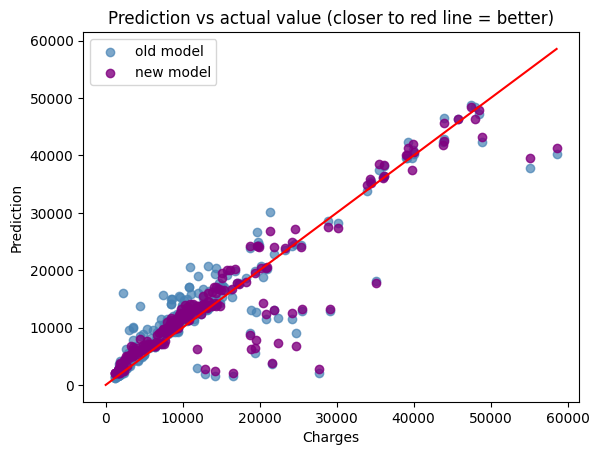

In [32]:
plt.scatter(y_test, forest_y_predict, color=(70/255, 130/255, 180/255, 0.7), label="old model")
plt.scatter(y_test, model_y_predict, color=(128/255, 0/255, 128/255, 0.8), label="new model")
plt.plot(np.linspace(0, max(y_test)), np.linspace(9, max(y_test)), color="red")
plt.xlabel("Charges")
plt.ylabel("Prediction")
plt.title("Prediction vs actual value (closer to red line = better)")
plt.legend()

### Model implementation

Lastly, here's an implementation of the model in another dataset.

In [33]:
validation_df = pd.read_csv("validation_dataset.csv")
validation_df = pd.get_dummies(df, prefix=["region"], columns=["region"])
validation_df = validation_df.drop(columns=["region_southeast"])

validation_df["smoker"] = (validation_df["smoker"] == "yes")
validation_df["smoker"] = validation_df["smoker"].astype("int64")

validation_df["is_male"] = (validation_df["sex"] == "male").astype("int64")

validation_df = validation_df.drop(columns=["sex", "charges"])

validation_df = validation_df.dropna()

validation_df.head()

,age,bmi,children,smoker,region_northeast,region_northwest,region_southwest,is_male
0,19.0,27.900,0.0,0,False,False,True,0
1,18.0,33.770,1.0,0,False,False,False,1
2,28.0,33.000,3.0,0,False,False,False,1
3,33.0,22.705,0.0,0,False,True,False,1
4,32.0,28.880,0.0,0,False,True,False,1


In [34]:
predictions = model.predict(validation_df)

validation_df["predicted_charges"] = predictions

validation_df.loc[validation_df["predicted_charges"] < 1000, "predicted_charges"] = 1000

validation_df

,age,bmi,children,smoker,region_northeast,region_northwest,region_southwest,is_male,predicted_charges
0,19.0,27.900,0.0,0,False,False,True,0,2480.767194
1,18.0,33.770,1.0,0,False,False,False,1,2949.559493
2,28.0,33.000,3.0,0,False,False,False,1,6088.056232
3,33.0,22.705,0.0,0,False,True,False,1,7212.123538
4,32.0,28.880,0.0,0,False,True,False,1,5087.370942
...,...,...,...,...,...,...,...,...,...
1203,50.0,30.970,3.0,0,False,True,False,1,10909.637490
1204,18.0,31.920,0.0,0,True,False,False,0,3304.237192
1205,18.0,36.850,0.0,0,False,False,False,0,2452.888815
1206,21.0,25.800,0.0,0,False,False,True,0,2516.053311


## **Conclusion and Closing**

Thank you for taking the time to explore this project with me. From data preparation to model validation, We’ve walked through the process of building a predictive model for insurance costs, highlighting key steps like cleaning data, comparing models, and fine-tuning performance.

If you have any questions or would like to dive deeper into specific aspects of the project, I’d be happy to assist!

You can contact me at *[business@falcontreras.com]* or alternatively there's a contact form within [falcontreras.com](https://falcontreras.com)

**Thank you!** 👋